In [452]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
from IPython.core.display import display, HTML
import datetime as dt

#visualization
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression  
from sklearn.model_selection import train_test_split

# Background

Dataset: https://physionet.org/content/mimiciii-demo/1.4/  
Data info: https://mimic.physionet.org/mimictables/callout/  
Full database: https://physionet.org/content/mimiciii/1.4/
ICD9 codes scraped from: https://en.wikipedia.org/wiki/List_of_ICD-9_codes_001%E2%80%93139:_infectious_and_parasitic_diseases

## Definitions
SUBJECT_ID: indicates a unique patient. There can be multiple instances which indicates readmittance.  

HADM_ID, represents a single patient’s admission to the hospital; cannot be duplicates  

ADMITTIME provides the date and time the patient was admitted to the hospital  

ISCHTIME provides the date and time the patient was discharged from the hospital  

DEATHTIME provides the time of in-hospital death for the patient  

ADMISSION_TYPE describes the type of the admission: ‘ELECTIVE’, ‘URGENT’, ‘NEWBORN’ or ‘EMERGENCY’. Emergency/urgent indicate unplanned medical care, and are often collapsed into a single category in studies. Elective indicates a previously planned hospital admission. Newborn indicates that the HADM_ID pertains to the patient’s birth  

ADMISSION_LOCATION provides information about the previous location of the patient prior to arriving at the hospital. There are 9 possible values:
* EMERGENCY ROOM ADMIT
* TRANSFER FROM HOSP/EXTRAM
* TRANSFER FROM OTHER HEALT
* CLINIC REFERRAL/PREMATURE
* ** INFO NOT AVAILABLE **
* TRANSFER FROM SKILLED NUR
* TRSF WITHIN THIS FACILITY
* HMO REFERRAL/SICK
* PHYS REFERRAL/NORMAL DELI  

EDREGTIME, EDOUTTIME: Time that the patient was registered and discharged from the emergency department  
  
DIAGNOSIS column provides a preliminary, free text diagnosis for the patient on hospital admission.  

HOSPITAL_EXPIRE_FLAG: This indicates whether the patient died within the given hospitalization. 1 indicates death in the hospital, and 0 indicates survival to hospital discharge.  

INSURANCE, LANGUAGE, RELIGION, MARITAL_STATUS, ETHNICITY columns describe patient demographics  

TRANSFERTIME is the time at which the patient moved from the previous service  

PREV_SERVICE and CURR_SERVICE are the previous and current service that the patient resides under.  

GENDER is the genotypical sex of the patient  

DOB is the date of birth of the given patient. Patients who are older than 89 years old at any time in the database have had their date of birth shifted to obscure their age and comply with HIPAA  

DOD is the date of death for the given patient  

SEQ_NUM provides the order in which the ICD diagnoses relate to the patient  

ICD9_CODE contains the actual code corresponding to the diagnosis assigned to the patient for the given row.  

SUBMIT_WARDID identifies the ward from which the request was submitted.

## Importing & Merging Datasets

In [557]:
def import_files(file_name):
    return pd.read_csv(f'data/{file_name}.csv')

admissions = import_files('admissions')
patients = import_files('patients')
diagnoses = import_files('diagnoses_icd')
services = import_files('services')

In [558]:
def common_columns(dataset1, dataset2):
    """takes two datasets and returns any columns that the two
    datasets have in common"""
    
    common = [col for col in dataset1.columns if col in dataset2.columns]
    return common

In [559]:
#identifying which columns admissions and patients share
adm_and_pat = common_columns(admissions, patients)
adm_and_pat

['row_id', 'subject_id']

In [560]:
raw_data = admissions.merge(patients, how='outer', on='subject_id')

In [561]:
raw_and_diagnoses = common_columns(raw_data, diagnoses)
raw_and_diagnoses

['subject_id', 'hadm_id']

In [562]:
raw_data = raw_data.merge(diagnoses, how='outer', on=('subject_id', 'hadm_id'))

In [563]:
los_and_services = common_columns(raw_data, services)
los_and_services

['subject_id', 'hadm_id', 'row_id']

In [564]:
raw_data = raw_data.merge(services, how='outer', on=('subject_id', 'hadm_id'))

In [565]:
raw_data.columns

Index(['row_id_x', 'subject_id', 'hadm_id', 'admittime', 'dischtime',
       'deathtime', 'admission_type', 'admission_location',
       'discharge_location', 'insurance', 'language', 'religion',
       'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
       'hospital_expire_flag', 'has_chartevents_data', 'row_id_y', 'gender',
       'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag', 'row_id_x',
       'seq_num', 'icd9_code', 'row_id_y', 'transfertime', 'prev_service',
       'curr_service'],
      dtype='object')

In [566]:
#removing columns that are repeated or unessesary 
keeping_cols = ['subject_id',
                'hadm_id',
                'admittime',
                'dischtime',
                'admission_type',
                'admission_location',
                'insurance',
                'language',
                'religion',
                'marital_status',
                'ethnicity',
                'gender',
                'dob',
                'deathtime',
                'icd9_code',
                'curr_service'
               ]

raw_data = raw_data[keeping_cols]

In [567]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2191 entries, 0 to 2190
Data columns (total 16 columns):
subject_id            2191 non-null int64
hadm_id               2191 non-null int64
admittime             2191 non-null object
dischtime             2191 non-null object
admission_type        2191 non-null object
admission_location    2191 non-null object
insurance             2191 non-null object
language              1516 non-null object
religion              2182 non-null object
marital_status        2048 non-null object
ethnicity             2191 non-null object
gender                2191 non-null object
dob                   2191 non-null object
deathtime             670 non-null object
icd9_code             2191 non-null object
curr_service          2191 non-null object
dtypes: int64(2), object(14)
memory usage: 291.0+ KB


## Cleaning Data

### Adding LOS column

In [568]:
#creating a copy to enable reverts
los_data = raw_data.copy()

In [569]:
# LOS will be calculated as the discharge time - admission time. 
# Before doing so, both columns must be converted to datetime types
los_data.admittime = pd.to_datetime(los_data.admittime)
los_data.dischtime = pd.to_datetime(los_data.dischtime)

#timedelta displays in days/hour/seconds, for analysis columns should be in hours
los_data['los'] = (pd.to_datetime(los_data.dischtime) - pd.to_datetime(los_data.admittime)).dt.total_seconds()/120

#removing discharge information for redundancy and becuase it would be unknown while patient is in the hospital
los_data = los_data.drop(columns=['dischtime'])

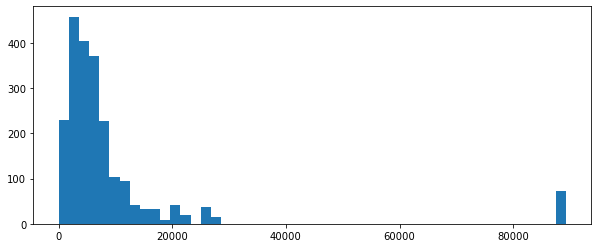

In [570]:
plt.figure(figsize=(10,4))
plt.hist(los_data.los, bins=50);

### Isolate first visit only

In [571]:
#for the first pass, predict LOS for first time patients only

In [623]:
def identifying_firsts(data):
    """for each subject_id, keep only the rows from the first ever visit"""
    first_visit_dict = {}
    first_by_subj = los_data.groupby('subject_id')['admittime'].first().reset_index()
    for row in first_by_subj.index:
        first_visit_dict[first_by_subj.iloc[row, 0]] = first_by_subj.iloc[row, 1]
    return first_visit_dict

def isolating_firsts(data):
    """Creates a new dataframe with only the first visit for each unique patient.
    Leverages identifying_firsts to create a reference dictionary to identify all
    rows that are part of the patients first time visits. There should be an equal 
    number of unique subject_ids in the origonal and new dataset."""
    
    unique_subjs_in_original_data = data.subject_id.nunique()
    first_visit_dict = identifying_firsts(los_data)
    first_visit_only = pd.DataFrame(columns=data.columns)
    
    for k, v in first_visit_dict.items():
        single_subj = data[(data.subject_id == k) & (data.admittime == v)]
        first_visit_only = first_visit_only.append(single_subj, ignore_index=True)
    
    new_data_unique_subjs = first_visit_only.subject_id.nunique()
    new_data_unique_hadm = first_visit_only.hadm_id.nunique()
    
    if unique_subjs_in_original_data == new_data_unique_subjs:
        print(f"Success! There are {new_data_unique_subjs} unique subject_ids in the origonal and new dataset and {new_data_unique_hadm} unique hadm_ids.")
    else:
        print(f"Something went wrong. There are {new_data_unique_subjs} in the new dataset and {unique_subjs_in_original_data} in the origonal.")
    
    return first_visit_only

In [693]:
first_visit_data = isolating_firsts(los_data)

Success! There are 100 unique subject_ids in the origonal and new dataset and 100 unique hadm_ids.


In [694]:
first_visit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 16 columns):
subject_id            1636 non-null object
hadm_id               1636 non-null object
admittime             1636 non-null datetime64[ns]
admission_type        1636 non-null object
admission_location    1636 non-null object
insurance             1636 non-null object
language              1073 non-null object
religion              1627 non-null object
marital_status        1501 non-null object
ethnicity             1636 non-null object
gender                1636 non-null object
dob                   1636 non-null object
deathtime             544 non-null object
icd9_code             1636 non-null object
curr_service          1636 non-null object
los                   1636 non-null float64
dtypes: datetime64[ns](1), float64(1), object(14)
memory usage: 204.6+ KB


### Removing subjects who died

In [695]:
#analysis assumes that the subject does not die while in the hopsital
first_visit_data = first_visit_data[first_visit_data.deathtime.isna()]

#to simplify data, removing any columns that are provide information only if individual has died
first_visit_data = first_visit_data.drop(columns = ['deathtime'])

first_visit_data.info()

### ICD9 codes

ICD-9-CM is a 6 digit number derived from the 9th edition of the International Classification of Diseases. The code is a standardize indication of diagnoses.

The dataset documentation explains that there is a decimal point implied between the third and fourth digit for all diagnosis other than V codes. The decimal is implied for V codes between the second and third digit. 

The first three numbers of the code indicate the general class of diagnosis and the numbers after the decimal place provide information into the specific condition within the general class of diagnosis. For the purpose of this analysis, we will consider only which of the 19 class options, the diagnosis falls into. 

Class codes will be scraped from Wikipedia. 

In [696]:
def load_for_scraping():
    url = "https://en.wikipedia.org/wiki/List_of_ICD-9_codes_E_and_V_codes:_external_causes_of_injury_and_supplemental_classification"
    response = requests.get(url)
    status = response.status_code
    if status == 200:
        print("Website loaded successfully!")
        page = response.text
        soup = BeautifulSoup(page, "lxml")
        return soup
    else:
        print(f"Status code: {status}")
    return

def scraping_icd9():
    """Scrapes the ICD-9 wikipedia page for ICD-9 codes and diagnoses"""
    soup = load_for_scraping()
    tables = soup.find(class_ = 'wikitable')
    diagnosis = {}
    rows = [row for row in tables.find_all('tr')]
    for row in rows[1:]:
        items = row.find_all('td')
        link = items[1].find('a')
        num_range = link.text
        name_column= items[2]
        name = name_column.text[:-2]
        diagnosis[num_range] = name
    return diagnosis
    
diagnosis_dict = scraping_icd9()
diagnosis_dict

Website loaded successfully!


{'001–139': 'Infectious and Parasitic Disease',
 '140–239': 'Neoplasm',
 '240–279': 'Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorder',
 '280–289': 'Diseases of the Blood and Blood-forming Organ',
 '290–319': 'Mental Disorder',
 '320–389': 'Diseases of the Nervous System and Sense Organ',
 '390–459': 'Diseases of the Circulatory Syste',
 '460–519': 'Diseases of the Respiratory Syste',
 '520–579': 'Diseases of the Digestive Syste',
 '580–629': 'Diseases of the Genitourinary Syste',
 '630–679': 'Complications of Pregnancy, Childbirth, and the Puerperiu',
 '680–709': 'Diseases of the Skin and Subcutaneous Tissu',
 '710–739': 'Diseases of the Musculoskeletal System and Connective Tissu',
 '740–759': 'Congenital Anomalie',
 '760–779': 'Certain Conditions originating in the Perinatal Perio',
 '780–799': 'Symptoms, Signs and Ill-defined Condition',
 '800–999': 'Injury and Poisonin',
 'E800–E999': 'Supplementary Classification of External Causes of Injury and Poisonin',
 'V

In [697]:
def create_icd_indicator_col(data):
    indicator = []
    data['icd_indicator'] = np.nan
    data.icd9_code = data.icd9_code.astype(str)
    
    for val in data.icd9_code:
        if val[0] == 'V':
            indicator.append(.1)
        if val[0] == 'E':
            indicator.append(.7)
        if (val[0] != 'E') & (val[0] != 'V'):
            indicator.append(float(val[:3]))
    data.icd_indicator = indicator
    return data

def converting_icd9_range(data):
    indicator = []
    keys = list(diagnosis_dict.keys())
    indicating_data = create_icd_indicator_col(data)
    
    #indicating_data['icd_diagnosis'] = diagnosis_dict[indicating_data.icd_range]
    for val in indicating_data.icd_indicator:
        if 1 <= val < 139:
            indicator.append(diagnosis_dict[keys[0]])
        elif 140 <= val <= 239:
            indicator.append(diagnosis_dict[keys[1]])
        elif 240 <= val <= 279:
            indicator.append(diagnosis_dict[keys[2]]) 
        elif 280 <= val <= 289:
            indicator.append(diagnosis_dict[keys[3]]) 
        elif 290 <= val <= 319:
            indicator.append(diagnosis_dict[keys[4]]) 
        elif 320 <= val <= 389:
            indicator.append(diagnosis_dict[keys[5]]) 
        elif 390 <= val <= 459:
            indicator.append(diagnosis_dict[keys[6]]) 
        elif 460 <= val <= 519:
            indicator.append(diagnosis_dict[keys[7]]) 
        elif 520 <= val <= 579:
            indicator.append(diagnosis_dict[keys[8]]) 
        elif 580 <= val <= 629:
            indicator.append(diagnosis_dict[keys[9]]) 
        elif 630 <= val <= 679:
            indicator.append(diagnosis_dict[keys[10]])
        elif 680 <= val <= 709:
            indicator.append(diagnosis_dict[keys[11]])
        elif 710 <= val <= 739:
            indicator.append(diagnosis_dict[keys[12]])
        elif 740 <= val <= 759:
            indicator.append(diagnosis_dict[keys[13]])
        elif 760 <= val <= 779:
            indicator.append(diagnosis_dict[keys[14]])
        elif 780 <= val <= 799:
            indicator.append(diagnosis_dict[keys[15]])
        elif 800 <= val <= 999:
            indicator.append(diagnosis_dict[keys[16]])
        elif val < .5:
            indicator.append(diagnosis_dict[keys[17]])
        elif .5 <= val < 1:
            indicator.append(diagnosis_dict[keys[18]])
        else:
            print(val)
    
    data['icd_range'] = indicator
            
    return data

def convert_icd9(data):
    converted_data = converting_icd9_range(data)
    
    #converted_data['icd_range'] = converted_data['icd_range'].astype(str)
    converted_data['icd_range'] = converted_data['icd_range'].str.lower()
    converted_data['icd_range'] = converted_data['icd_range'].str.replace(' ', '_')
    
    converted_data = converted_data.drop(columns=['icd9_code', 'icd_indicator'])
    
    return converted_data

In [698]:
first_visit_data = convert_icd9(first_visit_data)

### Updating Language to English, Other, Unkown

In [699]:
first_visit_data.language.unique()

array([nan, 'POLI', 'ENGL', 'RUSS', 'SPAN'], dtype=object)

In [700]:
first_visit_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1092 entries, 0 to 1635
Data columns (total 15 columns):
subject_id            1092 non-null object
hadm_id               1092 non-null object
admittime             1092 non-null datetime64[ns]
admission_type        1092 non-null object
admission_location    1092 non-null object
insurance             1092 non-null object
language              765 non-null object
religion              1092 non-null object
marital_status        1032 non-null object
ethnicity             1092 non-null object
gender                1092 non-null object
dob                   1092 non-null object
curr_service          1092 non-null object
los                   1092 non-null float64
icd_range             1092 non-null object
dtypes: datetime64[ns](1), float64(1), object(13)
memory usage: 136.5+ KB


In [701]:
def converting_langauge(data):
    data.language = data.language.fillna('UNKNOWN')
    ind_language = list(data.columns).index('language')
    for i in range(data.shape[0]):
        if (data.iloc[i, ind_language] == 'ENGL'):
            data.iloc[i, ind_language] = 'ENGL'
        elif (data.iloc[i, ind_language] == 'UNKNOWN'):
            data.iloc[i, ind_language] = 'UNKNOWN'
        elif (data.iloc[i, ind_language] != 'ENG'):
            data.iloc[i, ind_language] = 'OTHER'
            
    return data

In [705]:
first_visit_data = converting_langauge(first_visit_data)

In [706]:
first_visit_data.language.unique()

array(['UNKNOWN', 'OTHER', 'ENGL'], dtype=object)

### Creating an age column

In [707]:
first_visit_data.admittime = pd.to_datetime(first_visit_data.admittime).dt.date
first_visit_data.dob = pd.to_datetime(first_visit_data.dob).dt.date

first_visit_data['age'] = (first_visit_data.admittime - first_visit_data.dob)

In [808]:
first_visit_data = first_visit_data[first_visit_data.age < 105]

In [810]:
first_visit_data.age.unique()

array([70.68219178, 73.7260274 , 70.12376679, 82.54794521, 78.50136986,
       88.06849315, 81.67945205, 75.9369863 , 88.09315068, 85.39178082,
       70.8       , 76.07123288, 81.69315068, 53.4       , 83.23013699,
       69.63561644, 75.71232877, 78.19726027, 85.18356164, 82.71506849,
       77.53972603, 27.89041096, 70.56438356, 63.78630137, 72.66849315,
       66.1260274 , 81.45753425, 83.32054795, 17.20273973, 51.6       ,
       65.37534247, 66.63013699, 76.38082192, 80.89041096, 83.59452055,
       76.98082192, 40.62739726, 87.20821918, 76.66575342, 72.5890411 ,
       86.31780822, 48.98082192, 55.07671233, 62.29589041, 43.86575342,
       72.77808219, 85.78630137, 77.27123288, 63.75890411, 85.65205479,
       80.61369863, 86.94520548, 79.6739726 , 76.9369863 , 61.95890411,
       55.13424658, 53.53972603, 71.68493151, 54.50136986, 45.46849315,
       73.11232877, 58.18630137])

In [710]:
mean = first_visit_data.loc[first_visit_data['age']<105, 'age'].mean()
first_visit_data.loc[first_visit_data.age > 105, 'age'] = np.nan
first_visit_data.age = first_visit_data.age.fillna(mean)

In [711]:
first_visit_data.age.unique()

array([70.68219178, 73.7260274 , 70.12376679, 82.54794521, 78.50136986,
       88.06849315, 81.67945205, 75.9369863 , 88.09315068, 85.39178082,
       70.8       , 76.07123288, 81.69315068, 53.4       , 83.23013699,
       69.63561644, 75.71232877, 78.19726027, 85.18356164, 82.71506849,
       77.53972603, 27.89041096, 70.56438356, 63.78630137, 72.66849315,
       66.1260274 , 81.45753425, 83.32054795, 17.20273973, 51.6       ,
       65.37534247, 66.63013699, 76.38082192, 80.89041096, 83.59452055,
       76.98082192, 40.62739726, 87.20821918, 76.66575342, 72.5890411 ,
       86.31780822, 48.98082192, 55.07671233, 62.29589041, 43.86575342,
       72.77808219, 85.78630137, 77.27123288, 63.75890411, 85.65205479,
       80.61369863, 86.94520548, 79.6739726 , 76.9369863 , 61.95890411,
       55.13424658, 53.53972603, 71.68493151, 54.50136986, 45.46849315,
       73.11232877, 58.18630137])

In [712]:
first_visit_data = first_visit_data.drop(columns = 'dob')

In [713]:
first_visit_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1092 entries, 0 to 1635
Data columns (total 15 columns):
subject_id            1092 non-null object
hadm_id               1092 non-null object
admittime             1092 non-null object
admission_type        1092 non-null object
admission_location    1092 non-null object
insurance             1092 non-null object
language              1092 non-null object
religion              1092 non-null object
marital_status        1032 non-null object
ethnicity             1092 non-null object
gender                1092 non-null object
curr_service          1092 non-null object
los                   1092 non-null float64
icd_range             1092 non-null object
age                   1092 non-null float64
dtypes: float64(2), object(13)
memory usage: 176.5+ KB


# Marital Status

In [714]:
first_visit_data.marital_status.unique()

array(['SEPARATED', 'DIVORCED', nan, 'MARRIED', 'WIDOWED',
       'UNKNOWN (DEFAULT)', 'SINGLE'], dtype=object)

In [717]:
def converting_marital_status(data):
    data.language = data.language.fillna('UNKNOWN')
    ind_ms = list(data.columns).index('marital_status')
    for i in range(data.shape[0]):
        if (data.iloc[i, ind_ms] == 'UNKNOWN (DEFAULT)'):
            data.iloc[i, ind_ms] = 'UNKOWN'
        elif (data.iloc[i, ind_ms] == 'MARRIED'):
            data.iloc[i, ind_ms] = 'CURRENTLY_MARRIED'
        elif (data.iloc[i, ind_ms] != 'SINGLE'):
            data.iloc[i, ind_ms] = 'SINGLE'
        else:
            data.iloc[i, ind_ms] = 'WAS_MARRIED'
            
    return data

In [720]:
first_visit_data = converting_marital_status(first_visit_data)

In [721]:
first_visit_data.marital_status.unique()

array(['WAS_MARRIED', 'SINGLE'], dtype=object)

# Admission Location

In [723]:
first_visit_data.admission_location.unique()

array(['EMERGENCY ROOM ADMIT', 'PHYS REFERRAL/NORMAL DELI',
       'TRANSFER FROM HOSP/EXTRAM', 'CLINIC REFERRAL/PREMATURE'],
      dtype=object)

In [729]:
def converting_admission_location(data):
    data.admission_location = data.admission_location.fillna('UNKNOWN')
    ind_al = list(data.columns).index('admission_location')
    for i in range(data.shape[0]):
        if (data.iloc[i, ind_al] == 'CLINICAL REFERRAL/PREMATURE') | (data.iloc[i, ind_al] == 'PHYS REFERRAL/NORMAL DELI'):
            data.iloc[i, ind_al] = 'REFERRAL'
        else:
            continue   
    return data

In [732]:
first_visit_data = converting_admission_location(first_visit_data)

In [733]:
first_visit_data.admission_location.unique()

array(['EMERGENCY ROOM ADMIT', 'REFERRAL', 'TRANSFER FROM HOSP/EXTRAM',
       'CLINIC REFERRAL/PREMATURE'], dtype=object)

### Religion

In [735]:
first_visit_data.religion.unique()

array(['CATHOLIC', 'OTHER', 'PROTESTANT QUAKER', 'NOT SPECIFIED',
       'UNOBTAINABLE', 'CHRISTIAN SCIENTIST', 'BUDDHIST', 'JEWISH',
       'MUSLIM'], dtype=object)

In [736]:
def converting_religions(data):
    data.religion = data.religion.fillna('UNKNOWN')
    ind_religion = list(data.columns).index('religion')
    for i in range(data.shape[0]):
        if (data.iloc[i, ind_religion] == 'UNOBTAINABLE') | (data.iloc[i, ind_religion] == 'NOT SPECIFIED'):
            data.iloc[i, ind_religion] = 'UNKNOWN'
        else:
            continue   
    return data

In [739]:
first_visit_data = converting_religions(first_visit_data)

In [740]:
first_visit_data.religion.unique()

array(['CATHOLIC', 'OTHER', 'PROTESTANT QUAKER', 'UNKNOWN',
       'CHRISTIAN SCIENTIST', 'BUDDHIST', 'JEWISH', 'MUSLIM'],
      dtype=object)

### Ethnicity

In [742]:
first_visit_data.ethnicity.unique()

array(['BLACK/AFRICAN AMERICAN', 'WHITE', 'UNKNOWN/NOT SPECIFIED',
       'ASIAN', 'HISPANIC OR LATINO', 'HISPANIC/LATINO - PUERTO RICAN',
       'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',
       'OTHER'], dtype=object)

In [747]:
def converting_ethnicity(data):
    data.ethnicity = data.ethnicity.fillna('UNKNOWN')
    ind_ethnicity = list(data.columns).index('ethnicity')
    for i in range(data.shape[0]):
        if (data.iloc[i, ind_ethnicity] == 'HISPANIC/LATINO - PUERTO RICAN') | (data.iloc[i, ind_ethnicity] == 'HISPANIC OR LATINO'):
            data.iloc[i, ind_ethnicity] = 'HISPANIC/LATINO'
        else:
            continue   
    return data

In [750]:
first_visit_data = converting_ethnicity(first_visit_data)

In [751]:
first_visit_data.ethnicity.unique()

array(['BLACK/AFRICAN AMERICAN', 'WHITE', 'UNKNOWN/NOT SPECIFIED',
       'ASIAN', 'HISPANIC/LATINO',
       'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',
       'OTHER'], dtype=object)

In [ ]:
### Current Service

In [752]:
first_visit_data.curr_service.unique()

array(['MED', 'NMED', 'CSURG', 'SURG', 'VSURG', 'CMED', 'OMED', 'NSURG',
       'TSURG', 'TRAUM', 'ORTHO', 'GU'], dtype=object)

### Confirm only one HADM assigned per individual

In [760]:
first_visit_data.subject_id.nunique()

67

In [761]:
first_visit_data.hadm_id.nunique()

67

In [762]:
first_visit_data = first_visit_data.drop(columns = 'hadm_id')

In [763]:
first_visit_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1092 entries, 0 to 1635
Data columns (total 14 columns):
subject_id            1092 non-null object
admittime             1092 non-null object
admission_type        1092 non-null object
admission_location    1092 non-null object
insurance             1092 non-null object
language              1092 non-null object
religion              1092 non-null object
marital_status        1092 non-null object
ethnicity             1092 non-null object
gender                1092 non-null object
curr_service          1092 non-null object
los                   1092 non-null float64
icd_range             1092 non-null object
age                   1092 non-null float64
dtypes: float64(2), object(12)
memory usage: 168.0+ KB


## Dummifying

In [822]:
dummy_data = first_visit_data.copy()

In [823]:
dummy_data = pd.concat((dummy_data, pd.get_dummies(dummy_data['icd_range'])), axis=1)

In [824]:
dummy_data = dummy_data.drop(columns = 'icd_range')
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1092 entries, 0 to 1635
Data columns (total 30 columns):
subject_id                                                                                           1092 non-null object
admittime                                                                                            1092 non-null object
admission_type                                                                                       1092 non-null object
admission_location                                                                                   1092 non-null object
insurance                                                                                            1092 non-null object
language                                                                                             1092 non-null object
religion                                                                                             1092 non-null object
marital_status                         

In [829]:
dummy_data = dummy_data.rename(columns = {'congenital_anomalie': 'd_anomalie',
                                          'diseases_of_the_blood_and_blood-forming_organ': 'd_blood', 
                                          'diseases_of_the_circulatory_syste': 'd_circulatory', 
                                          'diseases_of_the_digestive_syste': 'd_digestive', 
                                          'diseases_of_the_genitourinary_syste': 'd_genitourinary', 
                                          'diseases_of_the_musculoskeletal_system_and_connective_tissu': 'd_musculoskeletal', 
                                          'diseases_of_the_nervous_system_and_sense_organ': 'd_nervous', 
                                          'diseases_of_the_respiratory_syste': 'd_respiratory', 
                                          'diseases_of_the_skin_and_subcutaneous_tissu': 'd_skin', 
                                          'endocrine,_nutritional_and_metabolic_diseases,_and_immunity_disorder': 'd_endo_metabolic_immunity', 
                                          'infectious_and_parasitic_disease': 'd_parasitic', 
                                          'injury_and_poisonin': 'd_poison_injury', 
                                          'mental_disorder': 'd_mental', 
                                          'neoplasm': 'd_neoplasm', 
                                          'supplementary_classification_of_external_causes_of_injury_and_poisonin': 'd_external_inj_poison', 
                                          'supplementary_classification_of_factors_influencing_health_status_and_contact_with_health_service': 'd_suppl_health_service', 
                                          'symptoms,_signs_and_ill-defined_condition':'d_ill_defined'})

In [830]:
grouped_dummy_data = dummy_data.groupby('subject_id').max().reset_index()

In [831]:
grouped_dummy_data.shape

(67, 30)

In [832]:
grouped_dummy_data['number_of_diagnoses'] = grouped_dummy_data['d_anomalie'] + grouped_dummy_data['d_blood'] + grouped_dummy_data['d_circulatory'] + grouped_dummy_data['d_digestive'] + grouped_dummy_data['d_digestive']

In [835]:
grouped_dummy_data.shape

(67, 31)